In [1]:
#Notebook for doing the actual classification

In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, MultimodalDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten, LateFusion, LSTMnet_RnnAtten_late
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.svm import SVC

In [2]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '.\\data\\MELD\\audio\\wav\\'

val_audio = '.\\data\\MELD\\audio\\wav_dev\\'

In [3]:
train = MultimodalDataset(train_annotations, train_audio, train_bert)
# val = MultimodalDataset(val_annotations, val_audio, val_bert)

train, val = train_test_split(train, test_size=0.2)
batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = False, drop_last=False)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))


In [4]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [5]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [30]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_audio = LSTMnet_RnnAtten_late(input_dim = 1611, hidden_dim=128, output_dim=7, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_audio.parameters()) )


Number of trainable params:  1255431


In [39]:
model_text = LSTMnet_RnnAtten_late(input_dim = 768, hidden_dim=128, output_dim=7, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_text.parameters()) )

Number of trainable params:  823815


In [40]:
model_audio.load_state_dict(torch.load("..\\audio\\best-model-parameters.pt"))
model_text.load_state_dict(torch.load("..\\text_only\\best-model-parameters.pt"))

<All keys matched successfully>

In [41]:
a = LateFusion().to(device)

In [50]:

OPTIMIZER = torch.optim.Adam(a.parameters(),lr=0.0001, weight_decay=1e-2) #???
train_step = make_train_step(a, loss_fnc, OPTIMIZER)
validate = make_validate_fnc(a,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 120 #
best_val_f1 = 0



for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        text = model_text(X_tensor[:,:768])
        audio = model_audio(X_tensor[:,768:])
        combined_tensor = torch.cat((audio, text), axis=1)
        loss, acc, f1= train_step(combined_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
   
    text_val = model_text(X_val_tensor[:,:768])
    audio_val = model_audio(X_val_tensor[:,768:])
    combined_tensor_val = torch.cat((audio_val, text_val), axis = 1)
 
    val_loss, val_acc, _, val_f1= validate(combined_tensor_val,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(a.state_dict(), 'best-model-parameters-latefusion.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
       
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")


Epoch 1 --> loss:1.3683, acc:51.30%, val_loss:1.4451, val_acc:45.31%  f1:47.51%, val_f1:34.90%

Epoch 2 --> loss:1.3442, acc:52.67%, val_loss:1.4235, val_acc:43.75%  f1:53.54%, val_f1:31.94%

Epoch 3 --> loss:1.3232, acc:53.95%, val_loss:1.3894, val_acc:50.00%  f1:49.62%, val_f1:39.77%

Epoch 4 --> loss:1.3022, acc:55.17%, val_loss:1.3484, val_acc:50.00%  f1:53.66%, val_f1:40.14%

Epoch 5 --> loss:1.2896, acc:55.81%, val_loss:1.3404, val_acc:51.56%  f1:56.58%, val_f1:42.79%

Epoch 6 --> loss:1.2724, acc:56.28%, val_loss:1.3647, val_acc:53.12%  f1:55.05%, val_f1:44.78%

Epoch 7 --> loss:1.2588, acc:57.05%, val_loss:1.3507, val_acc:51.56%  f1:58.66%, val_f1:41.39%

Epoch 8 --> loss:1.2512, acc:57.59%, val_loss:1.3173, val_acc:57.81%  f1:53.81%, val_f1:49.73%

Epoch 9 --> loss:1.2406, acc:58.14%, val_loss:1.3111, val_acc:60.94%  f1:55.27%, val_f1:54.18%

Epoch 10 --> loss:1.2331, acc:58.38%, val_loss:1.2815, val_acc:56.25%  f1:53.32%, val_f1:47.50%

Epoch 11 --> loss:1.2270, acc:58.84%, 

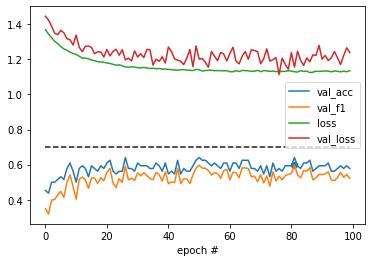

In [51]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()





In [52]:
for param in a.parameters():
  print(param.data)

tensor([[-0.0708, -0.1002, -0.0840, -0.0387,  0.1029,  0.0213, -0.1142,  0.4816,
         -0.1119,  0.0718,  0.0348, -0.3011,  0.1549, -0.0913],
        [ 0.0289, -0.0573, -0.0456,  0.0276, -0.1183, -0.0210,  0.0453,  0.0971,
          0.3354,  0.3787,  0.0049, -0.1332,  0.1366,  0.0820],
        [ 0.0258, -0.0254, -0.0567,  0.0289,  0.0569, -0.0238,  0.0376, -0.1051,
          0.2955,  0.2637, -0.0502, -0.1748,  0.1930,  0.0271],
        [ 0.0157, -0.0493, -0.1042,  0.0426,  0.0931,  0.0152, -0.0172,  0.1068,
          0.0506, -0.3087,  0.4824, -0.2498, -0.4659, -0.2339],
        [-0.0128, -0.1449,  0.0201,  0.0105,  0.0787,  0.0420, -0.1066, -0.3253,
         -0.2953, -0.2127, -0.1022,  0.4251,  0.0779, -0.1762],
        [-0.0476, -0.0751, -0.1176,  0.0080, -0.0259, -0.0044, -0.0335,  0.1399,
          0.1983,  0.0047, -0.3355, -0.1479,  0.0959, -0.1935],
        [-0.0046, -0.1902,  0.0210, -0.0122,  0.0270, -0.0308, -0.0274, -0.2850,
         -0.1084, -0.3193, -0.3765, -0.4647, -0.2